In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from DecisionTree import DecisionTree
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from BaggingClassifier import BaggingClassifier
%run DecisionTree.py


In [ ]:
# Load dataset
data = pd.read_csv('heart.csv')
# Binary encoding for 'Sex' and 'ExerciseAngina'
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
# Extract features and labels
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

# One-Hot Encoding for non-binary categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = OneHotEncoder(sparse=False)

if categorical_cols:  # Only encode if there are categorical features
    encoded_array = encoder.fit_transform(X[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
    X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

X = X.to_numpy()
y = y.to_numpy()

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#X_val (10%) → Used for hyperparameter tuning.
# X_test (20%) → Used for final evaluation.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp
)

In [154]:
# tune the hyperparameters of the DecisionTree model
max_depths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
min_samples_splits = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100]

# Initialize best hyperparameters
best_max_depth = None
best_min_samples_split = None
best_accuracy = 0

# Tune hyperparameters
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        model = DecisionTree(max_depth=max_depth, min_sample_split=min_samples_split)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        if accuracy > best_accuracy:
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_accuracy = accuracy
            

In [156]:
# Train the DecisionTree model with the best hyperparameters
model = DecisionTree(max_depth=best_max_depth, min_sample_split=best_min_samples_split)
model.fit(X_train, y_train)

# get predictions and accuracy of the DecisionTree model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of DecisionTree: {accuracy}")

Accuracy of DecisionTree: 0.8152173913043478


F1 Score of DecisionTree: 0.8247422680412372


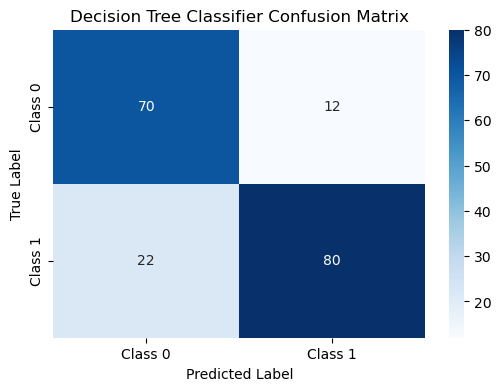

In [ ]:
# calculate the F1 score of the DecisionTree model
f1 = f1_score(y_test, y_pred)
print(f"F1 Score of DecisionTree: {f1}")
# Plot Confusion Matrix for DecisionTree
conf_matrix = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix, "Decision Tree Classifier Confusion Matrix")

use X_val to tune the model during training, and use X_test to evaluate the model after training.

In [169]:
# Train the Bagging Classifier
bagging_model = BaggingClassifier(base_learner=DecisionTree, n_estimators=20)
bagging_model.fit(X_train, y_train)

# Predict using Bagging Classifier
val_set = bagging_model.predict(X_val)
# Compute accuracy
accuracy = accuracy_score(y_val, val_set)
print(f"Bagging Classifier Validation Accuracy: {accuracy:.4f}")


Bagging Classifier Validation Accuracy: 0.8804


Bagging Classifier evaluation

In [124]:
# Predict using Bagging Classifier
y_pred = bagging_model.predict(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


In [125]:
# Print accuracy and F1-score
print(f"Bagging Classifier Test Accuracy: {accuracy:.4f}")
print(f"Bagging Classifier F1-Score: {f1:.4f}")

Bagging Classifier Test Accuracy: 0.8533
Bagging Classifier F1-Score: 0.8670


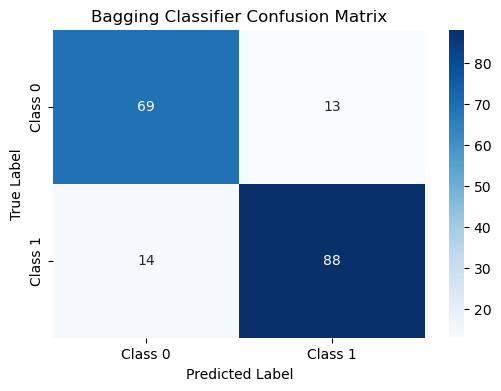

In [126]:
# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix, "Bagging Classifier Confusion Matrix")